In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


http://www.mcmchandbook.net/HandbookChapter5.pdf
En MC Hamiltoniano, el recorrido en el espacio de parámetros va a estar dado por un hamiltoniano clásico.
H(p,q) = -ln(f(p,q)) donde M es una matriz de masa (hace las de sigma)


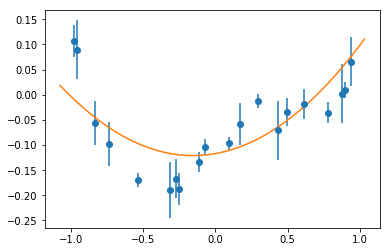

In [52]:
#Código de prueba
#!wget https://raw.githubusercontent.com/ComputoCienciasUniandes/MetodosComputacionalesAvanzados/master/ejercicios/data/fitting.txt

def loglikelihood(x_obs, y_obs, sigma_y_obs, param):
    d = y_obs -  model(x_obs, param)
    d = d/sigma_y_obs
    d = -0.5 * np.sum(d**2)
    return d


def model(x,param):
    n_param = len(param)
    y = 0
    for i in range(n_param):
        y += param[i] * x**i
    return y 


def hamiltonian(x_obs, y_obs, sigma_y_obs, param, param_momentum):
    m = 100.0
    K = 0.5 * np.sum(param_momentum**2)/m
    V = -loglikelihood(x_obs, y_obs, sigma_y_obs, param)     
    return K + V

def diff_potential(x_obs, y_obs, sigma_y_obs, param):
    n_param = len(param)
    div = np.ones(n_param)
    delta = 1E-5
    for i in range(n_param):
        delta_parameter = np.zeros(n_param)
        delta_parameter[i] = delta
        div[i] = loglikelihood(x_obs, y_obs, sigma_y_obs, param + delta_parameter) 
        div[i] = div[i] - loglikelihood(x_obs, y_obs, sigma_y_obs, param - delta_parameter)
        div[i] = div[i]/(2.0 * delta)
    return div

#Se actualiza medio dt en p, se actualiza 
def leapfrog_proposal(x_obs, y_obs, sigma_y_obs, param, param_momentum):
    N_steps = 5
    delta_t = 1E-3
    m = 10.0
    new_param = param.copy()
    new_param_momentum = param_momentum.copy()
    for i in range(N_steps):
        new_param_momentum = new_param_momentum + diff_potential(x_obs, y_obs, sigma_y_obs, param) * 0.5 * delta_t
        new_param = new_param + (new_param_momentum/m) * delta_t
        new_param_momentum = new_param_momentum + diff_potential(x_obs, y_obs, sigma_y_obs, param) * 0.5 * delta_t
    new_param_momentum = -new_param_momentum
    return new_param, new_param_momentum


def monte_carlo(x_obs, y_obs, sigma_y_obs,grado=3, N=2000):
    param = [np.random.random(grado)]
    param_momentum = [np.random.normal(size=grado)]
    for i in range(1,N):
        propuesta_param, propuesta_param_momentum = leapfrog_proposal(x_obs, y_obs, sigma_y_obs, param[i-1], param_momentum[i-1])
        energy_new = hamiltonian(x_obs, y_obs, sigma_y_obs, propuesta_param, propuesta_param_momentum)
        energy_old = hamiltonian(x_obs, y_obs, sigma_y_obs, param[i-1], param_momentum[i-1])
   
        r = min(1,np.exp(-(energy_new - energy_old)))
        alpha = np.random.random()
       # print(r,alpha)
        if(alpha<r):
            param.append(propuesta_param)
        else:
            param.append(param[i-1])
        param_momentum.append(np.random.normal(size=grado))    

    param = np.array(param)
    return param



datosHMC = np.loadtxt('fitting.txt')
sigma_real = datosHMC[:,2]
y_real = datosHMC[:,1]
x_real = datosHMC[:,0]
x = np.linspace(np.min(x_real)*1.1,np.max(x_real)*1.1,100)
fit = monte_carlo(x_real,y_real,sigma_real)
best = []
for i in range(len(fit[0])):
    best.append(np.mean(fit[:,i]))
plt.errorbar(x_real,y_real, yerr=sigma_real, fmt='o', label='obs')
plt.plot(x,model(x,param=best))


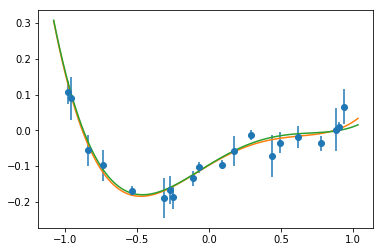

In [74]:
#Montecarlo clásico.
#Good ol'Metropolis
def metropolis(x_obs, y_obs, sigma_obs,grade=3, N = 50000):
    l_param = [np.random.random(grade)]
    sigma_param = np.array([0.1]* grade)
    n_param = len(sigma_param)
    logposterior = [0]
    for i in range(1,N):
        propuesta  = l_param[i-1] + np.random.normal(size=n_param)*sigma_param
        #print(propuesta)
        logposterior_viejo = loglikelihood(x_obs, y_obs, sigma_obs,param=l_param[i-1]) 
        logposterior_nuevo = loglikelihood(x_obs, y_obs, sigma_obs,param=propuesta) 

        r = min(1,np.exp(logposterior_nuevo-logposterior_viejo))
        alpha = np.random.random()
        if(alpha<r):
            l_param.append(propuesta)
            logposterior.append(logposterior_nuevo)
        else:
            l_param.append(l_param[i-1])
            logposterior.append(logposterior_viejo)
    
    l_param = np.array(l_param)
    l_param = l_param[N//10:,:] # descartamos el primer 10% de la cadena
    logposterior = np.array(logposterior)
    logposterior = logposterior[N//10:]
    return l_param, logposterior


datosMetropolis = np.loadtxt('fitting.txt')
sigma_real = datosMetropolis[:,2]
y_real = datosMetropolis[:,1]
x_real = datosMetropolis[:,0]
x = np.linspace(np.min(x_real)*1.1,np.max(x_real)*1.1,100)
fit, like = metropolis(x_real,y_real,sigma_real,grade=5)
best = []
for i in range(len(fit[0])):
    best.append(np.mean(fit[:,i]))
plt.errorbar(x_real,y_real, yerr=sigma_real, fmt='o', label='obs')
plt.plot(x,model(x,param=best))
plt.plot(x,model(x,param=fit[np.argmax(like)]))


In [70]:
fit[0][0]

array([-0.10476972,  0.04304711,  0.09702681])

In [58]:
np.zeros(100)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])